# Deep-Learning Classification of Play Type in NFL Play-By-Play Data

### Ian Johnson, Derek Phanekham, Travis Siems

## Introduction

The NFL (National Football League) has 32 teams split into two conferences, the AFC and NFC. Each of the 32 teams plays 16 games during the regular season (non-playoff season) every year. Due to the considerable viewership of American football, as well as the pervasiveness of fantasy football, considerable data about the game is collected. During the 2015-2016 season, information about every play from each game that occurred was logged. All of that data was consolidated into a single data set which is analyzed throughout this report.

In this report, we will attempt to classify the type of a play, given the game situation before the play began. 

### The Classification Task

We will attempt to classify plays based on play type using information about the state of the game prior to the start of the play. This is expected to be an exceptionally difficult classification task, due to the amount of noise in the dataset (specifically, the decision to run vs pass the ball is often a seemingly random one). A successful classifier would have huge value to defensive coordinators, who could call plays based on the expected offensive playcall. Because it may be very difficult to identify what play will be called, it is relevant to provide a probability of a given playcall in a situation. For example, it would be useful to provide the probability of a 4th down conversion attempt, even if the overall prediction is that a punt occurs. 

### Data Preparation

In order to prepare the data for classification, a number of variables from the original dataset will be removed, as they measure the result of the play, not the state of the game prior to the start of the play. The dataset being included in this report has had previous cleaning and preprocessing performed in our previous report.

In [45]:
#For final version of report, remove warnings for aesthetics.
import warnings
warnings.filterwarnings('ignore')

#Libraries used for data analysis
import pandas as pd
import numpy as np
from sklearn import preprocessing

df = pd.read_csv('data/cleaned.csv') # read in the csv file



colsToInclude = [ 'Drive', 'qtr', 'down',
                 'TimeSecs', 'yrdline100','ydstogo','ydsnet',
                 'GoalToGo','posteam','DefensiveTeam',
                 'PosTeamScore','ScoreDiff', 'PlayType']

df = df[colsToInclude]
df = df[[p not in ["Sack", "No Play", "QB Kneel", "Spike"] for p in df.PlayType]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38600 entries, 0 to 42875
Data columns (total 13 columns):
Drive            38600 non-null int64
qtr              38600 non-null int64
down             38600 non-null int64
TimeSecs         38600 non-null float64
yrdline100       38600 non-null float64
ydstogo          38600 non-null float64
ydsnet           38600 non-null float64
GoalToGo         38600 non-null int64
posteam          38600 non-null object
DefensiveTeam    38600 non-null object
PosTeamScore     38600 non-null float64
ScoreDiff        38600 non-null float64
PlayType         38600 non-null object
dtypes: float64(6), int64(4), object(3)
memory usage: 4.1+ MB


#### Neural Network Embeddings

We will use neural network embeddings from TensorFlow for the posteam and DefensiveTeam. However, we will be building these embeddings manually using one-hot encoding and additional fully-connected layers in each of the deep architectures. The following Python function was used for one-hot encoding, and was adapted from the website referenced in the code.

In [46]:
from sklearn.feature_extraction import DictVectorizer

#Simple function for 1 hot encoding
def encode_onehot(df, cols):
    """
    One-hot encoding is applied to columns specified in a pandas DataFrame.
    
    Modified from: https://gist.github.com/kljensen/5452382
    
    Details:
    
    http://en.wikipedia.org/wiki/One-hot
    http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

df = encode_onehot(df, cols=['posteam', 'DefensiveTeam'])

The following are descriptions of the remaining data columns in the play-by-play dataset. Note that the one-hot encoded columns do not follow the structure listed below, but for the sake of readability they are presented as if they were not one-hot encoded.

* **GameID** (*nominal*): A unique integer which identifies each game played 
* **Drive** (*ordinal*): The number of the drive during a game when the play occurred (indexed at one, so the first drive of the game has Drive 1 and the nth drive has Drive n)
* **qtr** (*interval*): The quarter of the game when the play occurred
* **down** (*interval*): The down when the play occurred (1st, 2nd, 3rd, or 4th)
* **TimeSecs** (*interval*): The remaining game time, in seconds, when the play began
* **yrdline100** (*ratio*): The absolute yard-line on the field where the play started (from 0 to 100, where 0 is the defensive end zone and 100 is the offensive end zone of the team with the ball)
* **ydstogo** (*ratio*): The number of yards from the line of scrimmage to the first-down line
* **ydsnet** (*ratio*): The number of yards from the beginning of the drive to the current line of scrimmage
* **GoalToGo** (*nominal*): A binary attribute whose value is 1 if there is no first down line (the end-zone is the first down line) or 0 if there is a normal first down line
* **posteam** (*nominal*): A 2-or-3 character code representing the team on offense
* **PosTeamScore** (*ratio*): The score of the team with possesion of the ball
* **DefensiveTeam** (*nominal*): A 2-or-3 character code representing the team on defense
* **ScoreDiff**: (*ratio*) The difference in score between the offensive and defensive at the time of the play.
* **PlayType**: (*nominal*) An attribute that identifies the type of play (i.e. Kickoff, Run, Pass, Sack, etc)

### Performance Metrics

The value of a classifier will be evaulated using the following cost matrix. Costs in the matrix which are set to 1 represent play predictions that would never actually occur in the context of a football game. For example, if we predicted a pass play and a kickoff occurs, then the classifier has a significant flaw. 

Bolded weights represent actual mispredictions that could occur.

|                | Actual Play | Pass | Run | Kickoff |     Punt    | Extra Point | Field Goal | Onside Kick |
|----------------|-------------|------|-----|---------|-------------|------------|-------------|-------------|
| Predicted Play |             |      |     |         |             |            |             | |
| Pass           |             | 0    | **0.1** | 1       | **0.15** | **0.15**        | **0.1**         | 1           |  
| Run            |             | **0.1**  | 0   | 1       | **0.15** | **0.15**        | **0.1**         | 1           | 
| Kickoff        |             | 1    | 1   | 0     |  1  | 1           | 1          | **0.75**       |
| Punt           |             | **0.25**    | **0.25**   | 1   | 0 |1       |  **0.15**           | 1           |
| Extra Point    |             | **0.4**  | **0.4** | 1       | 1 | 0           | 1          | 1           |
| Field Goal     |             | **0.4** | **0.4** | 1       | **0.1** | 1           | 0          | 1           |
| Onside Kick    |             | 1    | 1   | **0.25**    |  1 |1           | 1          | 0           |


This performance metric is the best for this classification problem because the actual potential cost of an incorrect play prediction varies significantly based on the nature of the misclassification. In an actual football game, it would be very costly to predict an extra point and have the opposing team run a pass play. This means that they ran a fake extra point and went for a two-point conversion. However, if a pass play is predicted and a run play occurs, the cost of the error is minimal because the defensive strategy for defending against run and pass plays.

Because the goal of this classification is to help inform defensive play-calling, a cost matrix is helpful because it allows a defensive coordinator to set his own costs to produce his own classifier, without any knowledge of the actualy computation that occurs.

### Cross Validation Methodology

We will use a stratified 10-fold cross validation technique to compare the models. We use a sequential partition of the data because this mirrors how data will be collected and analyzed. For our use, we assume that it is okay to use data in the “future” to predict data “now” because it can represent data from a previous football season. For example, if we use the first 90% of data for training and the remaining 10% of data for testing, that would simulate using most of the current season's data to predict plays towards the end of this season. If we use the first 50% and last 40% of data for training and the remaining 10% for testing, this would simulate using 40% of the previous season's data and the first 50% of this season's data to predict plays happening around the middle of the current season. 

By using stratification, we can use a more representative sample of the distribution of play types. This stratified sample will reduce variance in the estimation. Given that the dataset only covers play-by-play data for one football season and using our assumptions, we can conclude that the stratified 10-fold cross validation technique will give us an ideal comparison between models.

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

#Using a 10-fold stratified shuffle split.
cv = StratifiedKFold(n_splits=10)

y,levels = pd.factorize(df.PlayType.values)
X = df.drop('PlayType', 1).values.astype(np.float32)


num_classes = len(levels)

## Modeling

Before we build any models, we define a cost function in Python below, which is used to test all of our forthcoming models. It computes the item-wise product of a confusion matrix and our cost matrix, and returns the sum of all of the elements in the resulting matrix. We also define a function to calculate area under roc curve for a multiclass classification problem.

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from scipy import interp

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

cost_mat =     [[0  ,.1  , 1   , .15 , 0.15, .1 , 1   ],
                [.1 , 0  , 1   , 0.15, 0.15, 0.1, 1   ],
                [1  , 1  , 0   , 1   , 1   , 1  , 0.75],
                [.25,0.25, 1   , 0   , 1   ,0.15,  1  ],
                [0.4, 0.4, 1   , 1   , 0   , 1  ,  1  ],
                [0.4, 0.4, 1   , 0.1 , 1   , 0  ,  1  ],
                [1  , 1  , 0.25, 1   , 1   , 1  ,  0  ]]

def cost(Y, yhat):
    return np.sum(np.multiply(confusion_matrix(Y,yhat), cost_mat))

def auc_of_roc(Y,yhat):
    classes = ['Pass', 'Run', 'Kickoff', 'Punt', 'Extra Point', 'Field Goal', 'Onside Kick']
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for c in classes:
        tempY = [x==c for x in Y]
        tempYhat = [x==c for x in yhat]
        
        fpr, tpr, thresholds = roc_curve(tempY, tempYhat)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=c+' (area = %0.2f)' % (roc_auc))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')

    mean_tpr /= len(classes)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    print(mean_auc)
    plt.show()
    
    return mean_auc

auc_roc_scorer = make_scorer(auc_of_roc)
scorer = make_scorer(cost)

### An Accessory Plotting Function

The following plotting function will be used for tuning hyperparameters for various algorithms.
It is adapted from one of the instructional ML notebooks for CSE 5393

In [49]:
#Adapted From MachineLearningNotebooks/09_Evaluation
#Credit: Dr. Eric Larson
def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, test_mean,
             color='blue', marker='o',
             markersize=5, label='testing cost')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='blue')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Cost')
    plt.legend(loc='upper right')

### First Deep Learning Architecture

In [50]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers

In [53]:
%%time

def deep_model(X, y):

    
    #Embeddings layer
    teamembeddings = layers.stack(X[:,11:75], layers.fully_connected, [20,4])
    teamembeddings = tf.nn.relu(teamembeddings)
    
    #Non-embeddings features
    otherfeatures = X[:,0:10]

    #Concatenate the embeddings with the non-embeddings
    tensors = tf.concat(1, [teamembeddings, otherfeatures])


    tensors = layers.stack(tensors, layers.fully_connected, [100,50])
    tensors = tf.nn.relu(tensors)

    pred, loss = learn.models.logistic_regression(tensors, y)
    
    return pred, loss

def tmp(X,y):
    
    return learn.models.logistic_regression(X, y)
    

classifier = learn.TensorFlowEstimator(model_fn=deep_model, 
                                       n_classes=7, batch_size=100,
                                       steps=1000, learning_rate=0.005)


scores = []
for train_index, test_index in cv.split(X, y):
    
    classifier.fit(X[train_index], y[train_index])
    yhat = classifier.predict(X[test_index])

    print(cost(y[test_index], yhat))
    scores.append(cost(y[test_index], yhat))

print(scores)

Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1854.15
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1878.25
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1965.6
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1808.15
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1807.4
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1828.65
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1735.95
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1660.85
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)


1689.5
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
Tensor("input:0", shape=(?, 74), dtype=float32)
Tensor("Relu_1:0", shape=(?, 50), dtype=float32)
1673.0
[1854.1499999999999, 1878.25, 1965.6000000000001, 1808.1500000000001, 1807.3999999999999, 1828.6499999999999, 1735.9499999999998, 1660.8499999999999, 1689.5, 1673.0]
CPU times: user 49.1 s, sys: 6.27 s, total: 55.4 s
Wall time: 41.9 s


In [10]:
X[0].astype(np.float32)

array([  2.01509094e+09,   1.00000000e+00,   1.00000000e+00,
        -1.00000000e+00,   3.60000000e+03,   3.50000000e+01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

### Second Deep Learning Architecture

### Architecture Comparison

#### Cost Difference


#### Area Under Multiclass ROC Curve Difference


## Deployment

In [25]:
X[2,]

array([  2.01509094e+09,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   3.56100000e+03,   6.20000000e+01,
         1.00000000e+01,   3.10000000e+01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [13]:
df.columns

Index(['GameID', 'Drive', 'qtr', 'down', 'TimeSecs', 'yrdline100', 'ydstogo',
       'ydsnet', 'GoalToGo', 'PosTeamScore', 'ScoreDiff', 'PlayType',
       'DefensiveTeam=ARI', 'DefensiveTeam=ATL', 'DefensiveTeam=BAL',
       'DefensiveTeam=BUF', 'DefensiveTeam=CAR', 'DefensiveTeam=CHI',
       'DefensiveTeam=CIN', 'DefensiveTeam=CLE', 'DefensiveTeam=DAL',
       'DefensiveTeam=DEN', 'DefensiveTeam=DET', 'DefensiveTeam=GB',
       'DefensiveTeam=HOU', 'DefensiveTeam=IND', 'DefensiveTeam=JAC',
       'DefensiveTeam=KC', 'DefensiveTeam=MIA', 'DefensiveTeam=MIN',
       'DefensiveTeam=NE', 'DefensiveTeam=NO', 'DefensiveTeam=NYG',
       'DefensiveTeam=NYJ', 'DefensiveTeam=OAK', 'DefensiveTeam=PHI',
       'DefensiveTeam=PIT', 'DefensiveTeam=SD', 'DefensiveTeam=SEA',
       'DefensiveTeam=SF', 'DefensiveTeam=STL', 'DefensiveTeam=TB',
       'DefensiveTeam=TEN', 'DefensiveTeam=WAS', 'posteam=ARI', 'posteam=ATL',
       'posteam=BAL', 'posteam=BUF', 'posteam=CAR', 'posteam=CHI',
       'poste

In [21]:
X[:,12:75].shape

(38600, 63)

In [15]:
df.head()

,GameID,Drive,qtr,down,TimeSecs,yrdline100,ydstogo,ydsnet,GoalToGo,PosTeamScore,...,posteam=OAK,posteam=PHI,posteam=PIT,posteam=SD,posteam=SEA,posteam=SF,posteam=STL,posteam=TB,posteam=TEN,posteam=WAS
0,2015091000,1,1,-1,3600.0,35.0,0.0,0.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015091000,1,1,1,3600.0,80.0,10.0,18.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015091000,1,1,1,3561.0,62.0,10.0,31.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015091000,1,1,2,3544.0,53.0,1.0,31.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015091000,1,1,1,3506.0,49.0,10.0,45.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
c

array([2, 6, 4, ..., 4, 4, 4])

In [21]:
yhat

array([4, 4, 4, ..., 4, 4, 4])

In [58]:
len(yhat)

38600

In [22]:
[sum(yhat == x) for x in range(10)]

[0, 0, 0, 0, 3856, 0, 0, 0, 0, 0]

In [78]:
X[:,10]

array([ 0.,  0.,  0., ..., -6., -6., -6.])

In [80]:
df.columns

Index(['GameID', 'Drive', 'qtr', 'down', 'TimeSecs', 'yrdline100', 'ydstogo',
       'ydsnet', 'GoalToGo', 'PosTeamScore', 'ScoreDiff', 'PlayType',
       'DefensiveTeam=ARI', 'DefensiveTeam=ATL', 'DefensiveTeam=BAL',
       'DefensiveTeam=BUF', 'DefensiveTeam=CAR', 'DefensiveTeam=CHI',
       'DefensiveTeam=CIN', 'DefensiveTeam=CLE', 'DefensiveTeam=DAL',
       'DefensiveTeam=DEN', 'DefensiveTeam=DET', 'DefensiveTeam=GB',
       'DefensiveTeam=HOU', 'DefensiveTeam=IND', 'DefensiveTeam=JAC',
       'DefensiveTeam=KC', 'DefensiveTeam=MIA', 'DefensiveTeam=MIN',
       'DefensiveTeam=NE', 'DefensiveTeam=NO', 'DefensiveTeam=NYG',
       'DefensiveTeam=NYJ', 'DefensiveTeam=OAK', 'DefensiveTeam=PHI',
       'DefensiveTeam=PIT', 'DefensiveTeam=SD', 'DefensiveTeam=SEA',
       'DefensiveTeam=SF', 'DefensiveTeam=STL', 'DefensiveTeam=TB',
       'DefensiveTeam=TEN', 'DefensiveTeam=WAS', 'posteam=ARI', 'posteam=ATL',
       'posteam=BAL', 'posteam=BUF', 'posteam=CAR', 'posteam=CHI',
       'poste

In [86]:
X[:,11]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [11]:
X.shape
#3,860

(38600, 75)

(1797, 64)


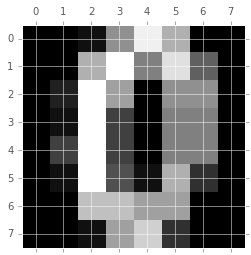

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[10]) 
plt.show() 

In [32]:
for train_index, test_index in cv.split(X, y):
    print(X[train_index,].shape)

(34737, 75)
(34737, 75)
(34738, 75)
(34739, 75)
(34739, 75)
(34740, 75)
(34741, 75)
(34742, 75)
(34743, 75)
(34744, 75)


In [11]:
num_classes

7

In [35]:
df.drop('PlayType', 1).values.astype(int)

array([[2015091000,          1,          1, ...,          0,          0,
                 0],
       [2015091000,          1,          1, ...,          0,          0,
                 0],
       [2015091000,          1,          1, ...,          0,          0,
                 0],
       ..., 
       [2016010310,         22,          4, ...,          0,          0,
                 0],
       [2016010310,         22,          4, ...,          0,          0,
                 0],
       [2016010310,         22,          4, ...,          0,          0,
                 0]])

In [41]:
X = df.drop('PlayType', 1).values.astype(np.int64)

array([[2015091000,          1,          1, ...,          0,          0,
                 0],
       [2015091000,          1,          1, ...,          0,          0,
                 0],
       [2015091000,          1,          1, ...,          0,          0,
                 0],
       ..., 
       [2016010310,         22,          4, ...,          0,          0,
                 0],
       [2016010310,         22,          4, ...,          0,          0,
                 0],
       [2016010310,         22,          4, ...,          0,          0,
                 0]])

In [54]:
y.dtype

dtype('int64')

In [48]:
X.dtype

dtype('int32')

In [55]:
y

array([0, 1, 2, ..., 2, 2, 2])

In [60]:
X.shape

(38600, 75)